# 导入相关库

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')
data=pd.read_csv('mbti_1.csv')
data.head()

d:\anaconda\envs\myenv\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# 数据查看

In [2]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [3]:
data['type'].value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

# 数据清洗
可以看到，数据集的posts里有很多网页链接等不相关的信息，这些无关信息需要被清洗以免影响预测准确性。

In [6]:
# 划分训练集和测试集

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

数据清洗的方法

In [7]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         去除链接
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         去除不重要的标点符号
        sentence=re.sub('[^0-9a-z\'\/]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [8]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:01<00:00, 4049.48it/s]


In [9]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:00<00:00, 3957.17it/s]


In [10]:
train_data.posts[0]

"'  and intj moments     sportscenter not top ten plays     pranks   what has been the most life changing experience in your life           on repeat for most of today    may the perc experience immerse you    the last thing my infj friend posted on his facebook before committing suicide the next day  rest in peace      enfj7  sorry to hear of your distress  it's only natural for a relationship to not be perfection all the time in every moment of existence  try to figure the hard times as times of growth  as      84389  84390             welcome and stuff       game  set  match    prozac  wellbrutin  at least thirty minutes of moving your legs  and i don't mean moving them while sitting in your same desk chair   weed in moderation  maybe try edibles as a healthier alternative      basically come up with three items you've determined that each type  or whichever types you want to do  would more than likely use  given each types' cognitive functions and whatnot  when left by      all thi

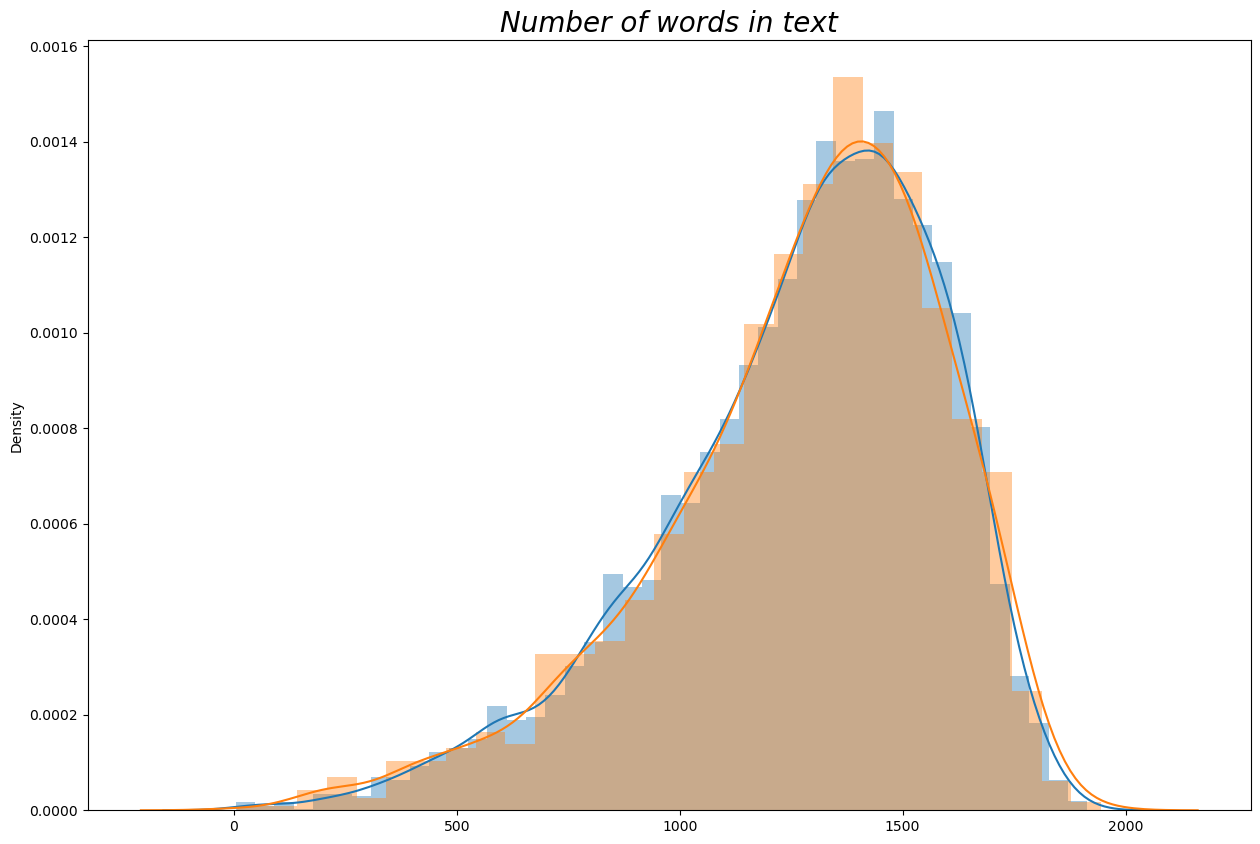

In [11]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [12]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

# 向量化

In [13]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x000001E44F390EB0>)

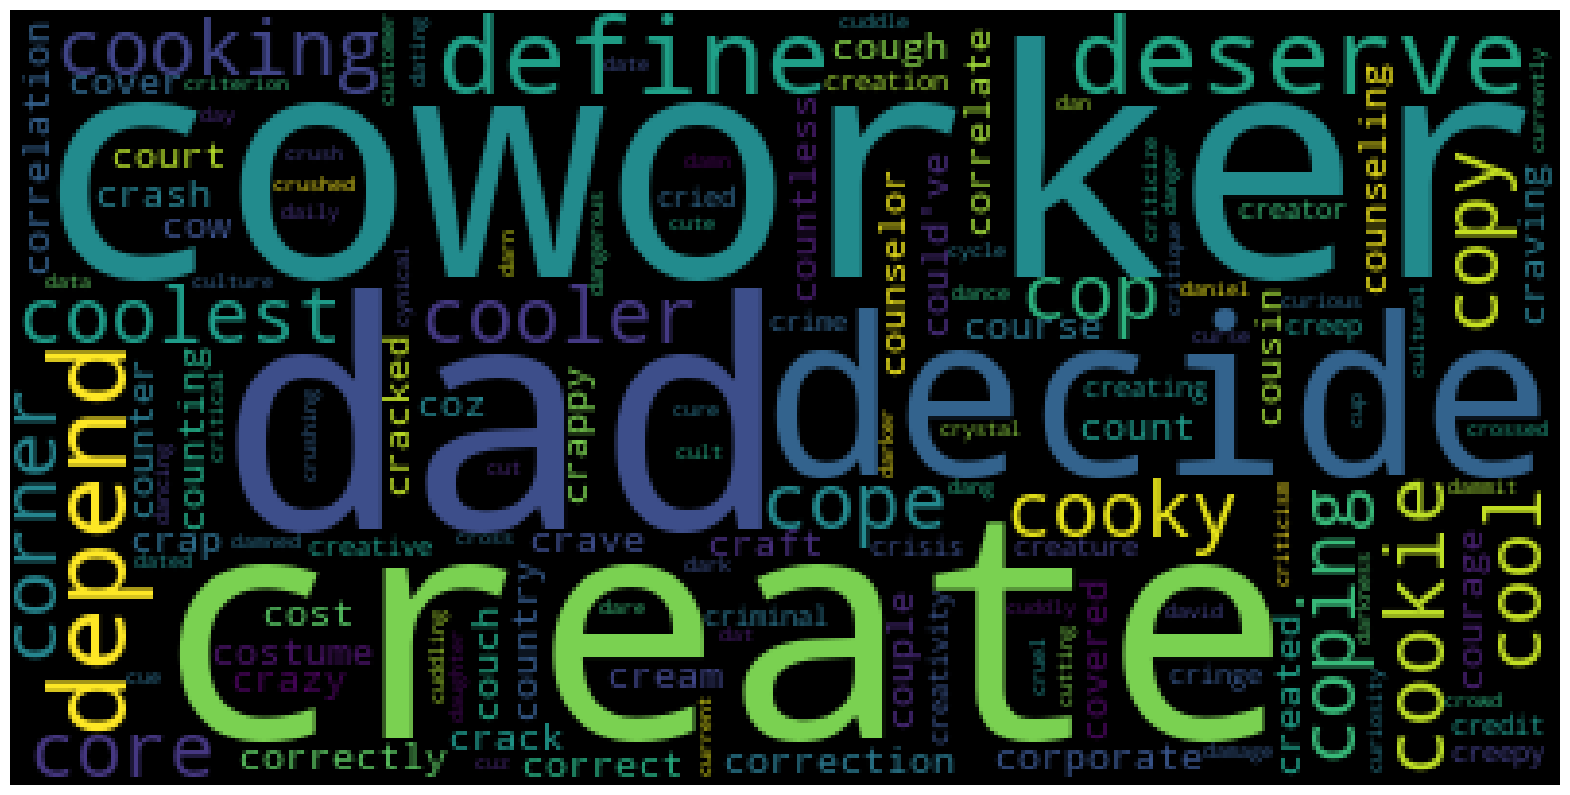

In [14]:
feature_names=vectorizer.get_feature_names_out()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[1000:1200] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

## 分开post和type，为训练做准备

In [15]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [16]:
train_post.shape

(6940, 5000)

In [17]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [18]:
train_target.shape

(6940,)

# 模型选择

In [19]:
models_accuracy={}

## Logistic Regression

In [20]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [21]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.78      0.12      0.21       152
        ENFP       0.80      0.62      0.70       540
        ENTJ       0.96      0.26      0.41       185
        ENTP       0.81      0.65      0.72       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.72      0.82      0.77      1176
        INFP       0.65      0.93      0.76      1466
        INTJ       0.73      0.80      0.76       873
        INTP       0.68      0.87      0.76      1043
        ISFJ       0.90      0.20      0.33       133
        ISFP       0.86      0.20      0.33       217
        ISTJ       0.83      0.21      0.34       164
        ISTP       0.86      0.47      0.61       270

    accuracy                           0.71      

In [22]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.05      0.10        38
        ENFP       0.75      0.53      0.62       135
        ENTJ       0.83      0.11      0.19        46
        ENTP       0.63      0.48      0.55       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.62      0.71      0.66       294
        INFP       0.56      0.89      0.69       366
        INTJ       0.61      0.65      0.63       218
        INTP       0.66      0.84      0.74       261
        ISFJ       0.67      0.06      0.11        33
        ISFP       0.88      0.13      0.23        54
        ISTJ       0.50      0.05      0.09        41
        ISTP       0.75      0.40      0.52        67

    accuracy                           0.62      17

In [23]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

## Linear Support Vector classifier

In [24]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

LinearSVC(C=0.1)

In [25]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.90      0.42      0.57       152
        ENFP       0.84      0.76      0.80       540
        ENTJ       0.93      0.62      0.75       185
        ENTP       0.83      0.81      0.82       548
        ESFJ       0.90      0.27      0.42        33
        ESFP       1.00      0.08      0.15        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.94      0.42      0.58        71
        INFJ       0.81      0.85      0.83      1176
        INFP       0.76      0.93      0.84      1466
        INTJ       0.82      0.85      0.84       873
        INTP       0.81      0.89      0.85      1043
        ISFJ       0.92      0.64      0.76       133
        ISFP       0.90      0.56      0.69       217
        ISTJ       0.89      0.66      0.76       164
        ISTP       0.90      0.80      0.85       270

    accuracy                           0.82      

In [26]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

## Decision Tree Classifier

In [27]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [28]:
print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.91      0.54      0.68       152
        ENFP       0.86      0.84      0.85       540
        ENTJ       0.85      0.72      0.78       185
        ENTP       0.91      0.79      0.85       548
        ESFJ       0.94      0.52      0.67        33
        ESFP       1.00      0.29      0.45        38
        ESTJ       0.80      0.26      0.39        31
        ESTP       0.73      0.46      0.57        71
        INFJ       0.90      0.85      0.87      1176
        INFP       0.63      0.94      0.76      1466
        INTJ       0.90      0.79      0.84       873
        INTP       0.90      0.82      0.86      1043
        ISFJ       0.95      0.62      0.75       133
        ISFP       0.96      0.62      0.75       217
        ISTJ       0.74      0.66      0.70       164
        ISTP       0.93      0.74      0.82       270

    accuracy                           0.81      

In [29]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

## XGBoost Classifier

In [30]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)

In [31]:
model_xgb.fit(train_post,train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.94      0.97       152
        ENFP       0.94      0.90      0.92       540
        ENTJ       1.00      0.91      0.95       185
        ENTP       0.94      0.91      0.93       548
        ESFJ       1.00      0.88      0.94        33
        ESFP       1.00      0.95      0.97        38
        ESTJ       1.00      0.87      0.93        31
        ESTP       1.00      0.96      0.98        71
        INFJ       0.92      0.91      0.91      1176
        INFP       0.89      0.95      0.92      1466
        INTJ       0.92      0.92      0.92       873
        INTP       0.90      0.92      0.91      1043
        ISFJ       1.00      0.94      0.97       133
        ISFP       0.97      0.94      0.95       217
        ISTJ       0.99      0.93      0.96       164
        ISTP       0.97      0.95      0.96       270

    accuracy                           0.92      

In [33]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

## 结果汇总

In [34]:
models_accuracy

{'logistic regression': 0.6201729106628242,
 'Linear Support Vector classifier': 0.6536023054755044,
 'Decision Tree classifier': 0.49394812680115274,
 'XGBoost Classifier': 0.6668587896253603}

In [35]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [36]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,XGBoost Classifier,0.666859
1,Linear Support Vector classifier,0.653602
2,logistic regression,0.620173
3,Decision Tree classifier,0.493948


### XGBoost分类器的预测准确率最高

# 改进策略：分别对四组指标进行推测

## 用二进制数组表示MBTI类型

In [37]:
import numpy as np
# 将MBTI的四组特征（四个字母）二元化

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # 用二进制数组表示一个MBTI类型
    return [b_Pers[l] for l in personality]

#将二进制数组还原成MBTI类型
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

train_personality_bi = np.array([translate_personality(p) for p in train_data.type])
test_personality_bi = np.array([translate_personality(p) for p in test_data.type])
print("Binarize MBTI list: \n%s" % train_personality_bi)
print(train_personality_bi.shape)

Binarize MBTI list: 
[[0 0 0 1]
 [0 1 1 1]
 [1 0 0 0]
 ...
 [1 0 1 0]
 [0 0 1 1]
 [1 0 1 1]]
(6940, 4)


In [38]:
personality_subtypes = ['I/E','N/S','F/T','J/P']
model2_xgb = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)

for i in range(len(personality_subtypes)):
    
    current_subtype_bi = train_personality_bi[:,i]

    # 训练模型，仍使用上面定义好的XGBoost分类器的超参数
    model2_xgb.fit(train_post, current_subtype_bi)

    subtype_predict = model2_xgb.predict(test_post)
    accuracy = accuracy_score(test_personality_bi[:,i], subtype_predict)
    
    print("%s Accuracy: %.2f%%" % (personality_subtypes[i], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_subtypes[i]))
    print(classification_report(train_personality_bi[:,i],model2_xgb.predict(train_post)))
    print("%s Classification report for Test Data" % (personality_subtypes[i]))
    print(classification_report(test_personality_bi[:,i], subtype_predict))
    print("\n")

I/E Accuracy: 85.24%
I/E Classification report for Train Data
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5342
           1       0.96      0.69      0.80      1598

    accuracy                           0.92      6940
   macro avg       0.93      0.84      0.87      6940
weighted avg       0.92      0.92      0.92      6940

I/E Classification report for Test Data
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1334
           1       0.77      0.51      0.62       401

    accuracy                           0.85      1735
   macro avg       0.82      0.73      0.76      1735
weighted avg       0.85      0.85      0.84      1735



N/S Accuracy: 89.63%
N/S Classification report for Train Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5983
           1       0.98      0.63      0.77       957

    accuracy    